<a href="https://colab.research.google.com/github/sgparrot/sgparrot2021Lv1-1/blob/main/Simpsons/Simpsons_Classification_20210518_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons Classification

In [ ]:
import os
import time
import glob
import zipfile

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, Adadelta
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

from pprint import pprint
from datetime import datetime
from sklearn.model_selection import train_test_split



### for notebook users
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
###train 폴더 속 하위 폴더 -> target 확인

target = os.listdir("/content/drive/MyDrive/Colab Notebooks/simpsons/train")
target.sort()

print("Number of targets: ",len(target))

category = {}
for i, name in enumerate(target):
    category[i]= name

pprint(category)

Number of targets:  9
{0: 'bart',
 1: 'charles_montgomery',
 2: 'krusty',
 3: 'lisa_simpson',
 4: 'marge_simpson',
 5: 'milhouse_van_houten',
 6: 'moe_szyslak',
 7: 'ned_flanders',
 8: 'principal_skinner'}


## 저장된 npz 파일 불러오기
구글드라이브에서 불러오는 데에 상당히 오래 걸리기 때문에, 한 번 불러온 후 npz 파일로 저장해놓은 상황. <br>
만약에 저장하는 코드가 보고 싶으시다면 0508 파일 참고해주세요.

In [ ]:
train_dataset = np.load("/content/drive/MyDrive/Colab Notebooks/simpsons/train_224_npz.npz")
test_dataset = np.load("/content/drive/MyDrive/Colab Notebooks/simpsons/test_224_npz.npz")

In [ ]:
X_train = train_dataset["X_train_npz"]
y_train = train_dataset["y_train_npz"]

y_train = to_categorical(y_train, len(target))

X_test = test_dataset["X_test_npz"]
y_test_list = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/test_sample.csv", index_col=0)
y_test = np.array(y_test_list["files"])

In [ ]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))   # 아직 어떻게 할지 못 정함

X_train shape: (11248, 224, 224, 3)
y_train shape: (11248, 9)
X_test shape: (1086, 224, 224, 3)
y_test shape: (1086,)


## Data Processing & Data Inspection

In [ ]:
train_batch_size = 64
test_batch_size = 64
image_size = 224

augmentor_train = A.Compose([
                             A.HorizontalFlip(p=0.5),
                             A.ShiftScaleRotate(p=0.75),
                             A.RandomBrightnessContrast(
                                 brightness_limit=(-0.25, 0.25),
                                 contrast_limit=(-0.25, 0.25), p=1
                                 ),   # 밝기와 대비 조절
                             A.CLAHE(p=1),   # Contrast-Limited Adaptive Histogram Equalization
                             A.OneOf([A.MotionBlur(p=1),   # Blur
                                      A.OpticalDistortion(p=1),   # 왜곡
                                      A.GaussNoise(p=1)], p=0.5),   # Noise
                             A.Cutout(num_holes = 32, max_h_size=4,
                                      max_w_size=4, p=0.75),   # dropout
                             A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
])

    

augmentor_test = A.Compose([A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))])

### Defining Dataloader

In [ ]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size,
                 augmentor= None, shuffle=False):   # augmentor가 추가됨

        """
        x_set, y_set: train set or test set (np.ndarray)
        batch_size: the size of data when a batch is enumerated (int)
        augmentor: data augmentor (albumantation, imgaug, ...)
        shuffle: whether shuffle the data or not after each epoch (boolean)
        """

        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size: (idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        # batch_size 쓰면 마지막 batch에서 문제 발생
        # 대안으로 indices.shape[0] 사용
        image_batch = np.zeros((indices.shape[0], image_size, image_size, 3))

        for image_index in range(indices.shape[0]):

            ### 이 안에서 다룰지, 밖에서 해결할지 고민 중
            ### image = cv2.cvtColor(cv2.imdead(indices.shape[image_index]), cv2.COLOR_BGR2RGB)
            ### image = cv2.resize(image, (image_size, image_size))

            image = batch_x[image_index]

            if self.augmentor is not None:
                image = self.augmentor(image=image)["image"]

            batch_x[image_index] = image
        
        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
train_loader = Dataloader(train_data, train_labels, batch_size=train_batch_size,
                          augmentor=augmentor_train, shuffle=True)
val_loader = Dataloader(val_data, val_labels, batch_size=train_batch_size,
                        augmentor=augmentor_train, shuffle=True)
test_loader = Dataloader(X_test, y_test, batch_size=test_batch_size,
                         augmentor=augmentor_test, shuffle=False)

In [ ]:
### 임시로 1개의 batch를 돌려서 잘 작동하는지 확인(Train Set)
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (64, 9)
Data  : (64, 224, 224, 3)


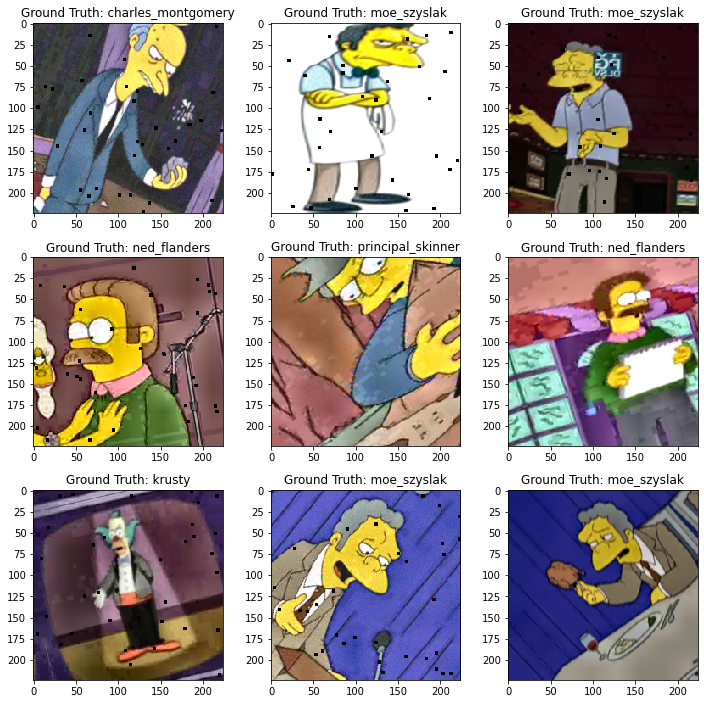

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(category.get(int(target))))

plt.show()

In [ ]:
### 임시로 1개의 batch를 돌려서 잘 작동하는지 확인(Test Set)
### Scaling을 제외한 Augmentation이 적용되면 안 됨!!!
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (64,)
Data  : (64, 224, 224, 3)


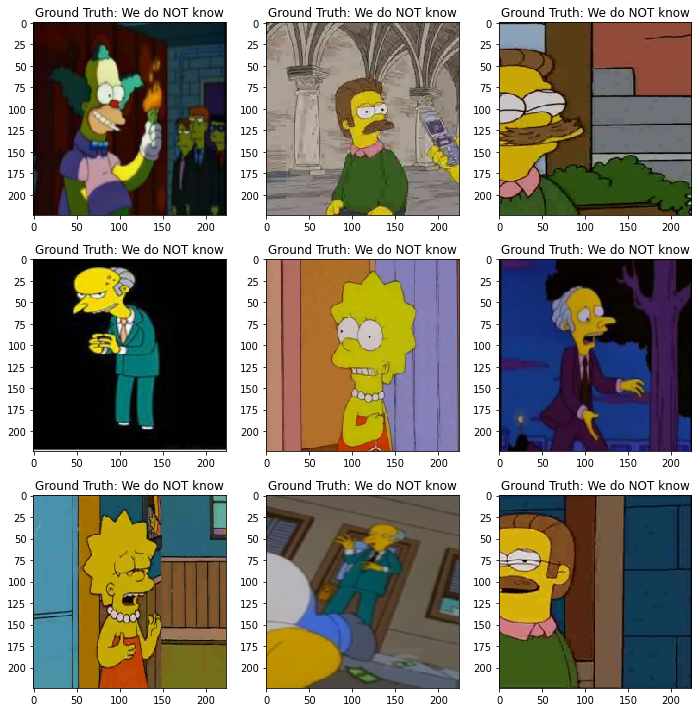

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format("We do NOT know"))

plt.show()

## CNN Modeling 1 (VGG16)
MNIST의 경우, size가 28 x 28로 너무 작아서 pretrained model을 이용하기 어려웠음. <br>
하지만 이번 dataset은 size가 충분히 크기 때문에 여러 pretrained model을 사용해보기로 함.

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, ResNet50V2, Xception

input_tensor= Input(shape=(224, 224, 3))

base_model = VGG16(input_tensor=input_tensor, include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)   # 원래 VGG 논문에서는 flatten을 썼는데, 그때는 GlobalAveragePooling이 없던 시절... 그러면 이게 맞지 않을까?
x = Dropout(rate=0.5)(x)
x = Dense(50, activation="relu", name="FC")(x)   # Dense 하나 더?
x = Dropout(rate=0.2)(x)
output = Dense(9, activation="softmax", name="Output")(x)


model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
earlystop = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=10,
                          verbose=1, mode="auto", baseline=None,
                          restore_best_weights=True)
learning_rate_reduction=ReduceLROnPlateau(monitor="val_accuracy", patience=3,
                                          verbose=1, factor=0.5, min_lr=0.0001)

### Cosine Decay Annealing

lr_Cosine_Decay = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=1e-4, first_decay_steps=141,
    t_mul=2, m_mul=0.9, alpha=0.0, name=None
)

In [ ]:
def plot_scheduler(epochs_list, lr_list, title=None):
    plt.figure(figsize=(6,4))
    plt.plot(epochs_list, lr_list)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title(title)

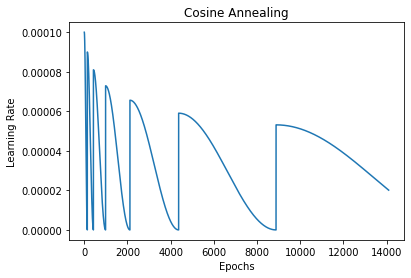

In [ ]:
steps_list = range(100*141)
lr_list = [lr_Cosine_Decay(step) for step in steps_list]

plot_scheduler(epochs_list, lr_list, title="Cosine Annealing")

In [ ]:
model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay), loss="categorical_crossentropy",
                  metrics=["accuracy"])
 
hist = model.fit(train_loader, batch_size=train_batch_size, epochs=100, validation_data=val_loader, verbose=1,
                 callbacks=[earlystop])

Epoch 1/100
141/141 [==============================] - 74s 511ms/step - loss: 2.2589 - accuracy: 0.1087 - val_loss: 2.1937 - val_accuracy: 0.1489
Epoch 2/100
141/141 [==============================] - 73s 516ms/step - loss: 2.1974 - accuracy: 0.1290 - val_loss: 2.1953 - val_accuracy: 0.1396
Epoch 3/100
141/141 [==============================] - 71s 505ms/step - loss: 2.1959 - accuracy: 0.1160 - val_loss: 2.1948 - val_accuracy: 0.1289
Epoch 4/100
141/141 [==============================] - 71s 503ms/step - loss: 2.1948 - accuracy: 0.1248 - val_loss: 2.1937 - val_accuracy: 0.1147
Epoch 5/100
141/141 [==============================] - 72s 507ms/step - loss: 2.1928 - accuracy: 0.1242 - val_loss: 2.1929 - val_accuracy: 0.1453
Epoch 6/100
141/141 [==============================] - 71s 503ms/step - loss: 2.1930 - accuracy: 0.1207 - val_loss: 2.1923 - val_accuracy: 0.1276
Epoch 7/100
141/141 [==============================] - 72s 505ms/step - loss: 2.1912 - accuracy: 0.1247 - val_loss: 2.1905 -

## Experiment


In [ ]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

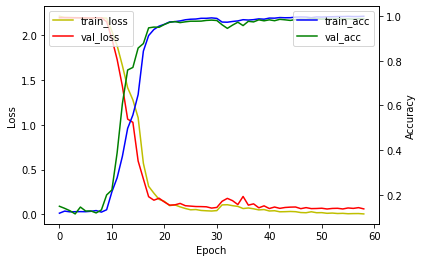

In [ ]:
acc_loss_plot(hist)

## Answer Sheet 만들기

In [ ]:
def y_train_writting(test_set_pics, test_set_names):

    """
    test_set_pics: X_test(numpy ndarray) or test_loader(enumerable)
    test_set_names: y_test (pandas DataFrame)
    """

    pred_integral = np.argmax(model.predict(test_set_pics), axis=-1)

    pred_categorical = []

    for prediction in pred_integral:

        if 0 <= prediction <= 8:
            pred_categorical.append(category[prediction])
        
        else:
            raise ValueError("Not a valid integral prediction.")
    
    test_set_names["pred"] = pred_categorical
    print(test_set_names)

    tm = time.localtime()
    file_name = "{0}{1}{2}_{3}{4}{5}".format(str(tm.tm_year).zfill(4),
                                             str(tm.tm_mon).zfill(2),
                                             str(tm.tm_mday).zfill(2),
                                             str(9 + tm.tm_hour).zfill(2),
                                             str(tm.tm_min).zfill(2),
                                             str(tm.tm_sec).zfill(2))

    test_set_names.to_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/answersheet/{0}.csv".format(file_name), mode="w")
    print("The answer sheet file is saved as {}.csv".format(file_name))

In [ ]:
y_train_writting(test_loader, y_test_list)

              files                 pred
0     test10013.jpg               krusty
1     test10019.jpg         ned_flanders
2     test10028.jpg         ned_flanders
3     test10074.jpg   charles_montgomery
4     test10084.jpg         lisa_simpson
...             ...                  ...
1081  test29955.jpg               krusty
1082  test29959.jpg          moe_szyslak
1083  test29963.jpg               krusty
1084  test29984.jpg  milhouse_van_houten
1085  test29998.jpg               krusty

[1086 rows x 2 columns]
The answer sheet file is saved as 20210514_213824.csv


## CNN Modeling 2 (Xception)

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, ResNet50V2, Xception

input_tensor= Input(shape=(224, 224, 3))

base_model = Xception(input_tensor=input_tensor, include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(128, activation="relu", name="FC")(x)   # Dense 하나 더?
x = Dropout(rate=0.2)(x)
output = Dense(9, activation="softmax", name="Output")(x)


model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
def lrfn(epoch):
    LR_START = 1e-5
    LR_MAX = 1e-2
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 3
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = ((LR_MAX - LR_START) / LR_RAMPUP_EPOCHS) * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
        
        print('epoch:', epoch, 'lr:', lr)
        
        return lr
    
    # 반드시 내포 함수인 calc_fn(epoch)를 호출해야함. 
    return calc_fn(epoch)

In [ ]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10,
                          verbose=1, mode="auto", baseline=None,
                          restore_best_weights=True)

### Cosine Decay Annealing

lr_Cosine_Decay = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=1e-4, first_decay_steps=141,
    t_mul=2, m_mul=0.8, alpha=0.0, name=None
)

### lr scheduler
lr_scheduler = LearningRateScheduler(lrfn)

In [ ]:
def plot_scheduler(epochs_list, lr_list, title=None):
    plt.figure(figsize=(6,4))
    plt.plot(epochs_list, lr_list)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title(title)

epoch: 0 lr: 1e-05
epoch: 1 lr: 0.0020080000000000002
epoch: 2 lr: 0.004006
epoch: 3 lr: 0.006004000000000001
epoch: 4 lr: 0.008002
epoch: 5 lr: 0.01
epoch: 6 lr: 0.01
epoch: 7 lr: 0.01
epoch: 8 lr: 0.01
epoch: 9 lr: 0.01
epoch: 10 lr: 0.0075
epoch: 11 lr: 0.0075
epoch: 12 lr: 0.005625
epoch: 13 lr: 0.005625
epoch: 14 lr: 0.00421875
epoch: 15 lr: 0.00421875
epoch: 16 lr: 0.0031640625
epoch: 17 lr: 0.0031640625
epoch: 18 lr: 0.002373046875
epoch: 19 lr: 0.002373046875
epoch: 20 lr: 0.00177978515625
epoch: 21 lr: 0.00177978515625
epoch: 22 lr: 0.0013348388671875
epoch: 23 lr: 0.0013348388671875
epoch: 24 lr: 0.001001129150390625
epoch: 25 lr: 0.001001129150390625
epoch: 26 lr: 0.0007508468627929688
epoch: 27 lr: 0.0007508468627929688
epoch: 28 lr: 0.0005631351470947266
epoch: 29 lr: 0.0005631351470947266
epoch: 30 lr: 0.00042235136032104493
epoch: 31 lr: 0.00042235136032104493
epoch: 32 lr: 0.0003167635202407837
epoch: 33 lr: 0.0003167635202407837
epoch: 34 lr: 0.00023757264018058776
epo

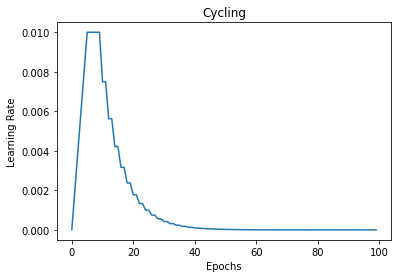

In [ ]:
epoch_list = range(100)
lr_list = [lrfn(epoch) for epoch in epoch_list]

plot_scheduler(epoch_list, lr_list, title="Cycling")

In [ ]:
model.compile(optimizer=Adam(), loss="categorical_crossentropy",
                  metrics=["accuracy"])
 
hist = model.fit(train_loader, batch_size=train_batch_size, epochs=100, validation_data=val_loader, verbose=1,
                 callbacks=[earlystop, lr_scheduler])

Epoch 1/100
epoch: 0 lr: 1e-05
141/141 [==============================] - 123s 847ms/step - loss: 2.2448 - accuracy: 0.1234 - val_loss: 2.1435 - val_accuracy: 0.1836
Epoch 2/100
epoch: 1 lr: 0.0020080000000000002
141/141 [==============================] - 118s 838ms/step - loss: 0.8440 - accuracy: 0.7328 - val_loss: 20.0970 - val_accuracy: 0.3302
Epoch 3/100
epoch: 2 lr: 0.004006
141/141 [==============================] - 119s 839ms/step - loss: 0.3998 - accuracy: 0.8907 - val_loss: 17.5935 - val_accuracy: 0.3822
Epoch 4/100
epoch: 3 lr: 0.006004000000000001
141/141 [==============================] - 118s 836ms/step - loss: 0.3185 - accuracy: 0.9137 - val_loss: 3.1872 - val_accuracy: 0.6827
Epoch 5/100
epoch: 4 lr: 0.008002
141/141 [==============================] - 119s 839ms/step - loss: 0.3622 - accuracy: 0.9070 - val_loss: 74.5162 - val_accuracy: 0.2987
Epoch 6/100
epoch: 5 lr: 0.01
141/141 [==============================] - 118s 837ms/step - loss: 0.3849 - accuracy: 0.8940 - val_l

In [ ]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

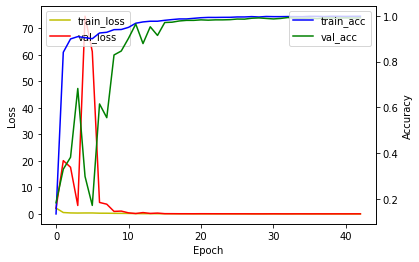

In [ ]:
acc_loss_plot(hist)

In [ ]:
def y_train_writting(test_set_pics, test_set_names):

    """
    test_set_pics: X_test(numpy ndarray) or test_loader(enumerable)
    test_set_names: y_test (pandas DataFrame)
    """

    pred_integral = np.argmax(model.predict(test_set_pics), axis=-1)

    pred_categorical = []

    for prediction in pred_integral:

        if 0 <= prediction <= 8:
            pred_categorical.append(category[prediction])
        
        else:
            raise ValueError("Not a valid integral prediction.")
    
    test_set_names["pred"] = pred_categorical
    print(test_set_names)

    tm = time.localtime()
    file_name = "{0}{1}{2}_{3}{4}{5}".format(str(tm.tm_year).zfill(4),
                                             str(tm.tm_mon).zfill(2),
                                             str(tm.tm_mday).zfill(2),
                                             str(9 + tm.tm_hour).zfill(2),
                                             str(tm.tm_min).zfill(2),
                                             str(tm.tm_sec).zfill(2))

    test_set_names.to_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/answersheet/{0}.csv".format(file_name), mode="w")
    print("The answer sheet file is saved as {}.csv".format(file_name))

In [ ]:
y_train_writting(test_loader, y_test_list)

              files                 pred
0     test10013.jpg               krusty
1     test10019.jpg         ned_flanders
2     test10028.jpg         ned_flanders
3     test10074.jpg   charles_montgomery
4     test10084.jpg         lisa_simpson
...             ...                  ...
1081  test29955.jpg               krusty
1082  test29959.jpg          moe_szyslak
1083  test29963.jpg               krusty
1084  test29984.jpg  milhouse_van_houten
1085  test29998.jpg               krusty

[1086 rows x 2 columns]
The answer sheet file is saved as 20210517_234641.csv


## CNN Modeling 3 (EfficientNet B3)

In [ ]:
from tensorflow.keras.applications import EfficientNetB3

input_tensor= Input(shape=(224, 224, 3))

base_model = EfficientNetB3(input_tensor=input_tensor, include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(128, activation="relu", name="FC")(x)   # Dense 하나 더?
x = Dropout(rate=0.2)(x)
output = Dense(9, activation="softmax", name="Output")(x)


model = Model(inputs=input_tensor, outputs=output)

model.summary()

43941888/43941136 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

In [ ]:
def lrfn(epoch):
    LR_START = 1e-5
    LR_MAX = 1e-2
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 3
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = ((LR_MAX - LR_START) / LR_RAMPUP_EPOCHS) * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
        
        print('epoch:', epoch + 1, 'lr:', lr)
        
        return lr
    
    # 반드시 내포 함수인 calc_fn(epoch)를 호출해야함. 
    return calc_fn(epoch)

In [ ]:
earlystop = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=10,
                          verbose=1, mode="auto", baseline=None,
                          restore_best_weights=True)
learning_rate_reduction=ReduceLROnPlateau(monitor="val_accuracy", patience=3,
                                          verbose=1, factor=0.5, min_lr=0.0001)

### Cosine Decay Annealing

lr_Cosine_Decay = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=1e-4, first_decay_steps=141,
    t_mul=2, m_mul=0.75, alpha=0.0, name=None
)

#lr_scheduler = LearningRateScheduler(lrfn)

In [ ]:
def plot_scheduler(epochs_list, lr_list, title=None):
    plt.figure(figsize=(6,4))
    plt.plot(epochs_list, lr_list)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title(title)

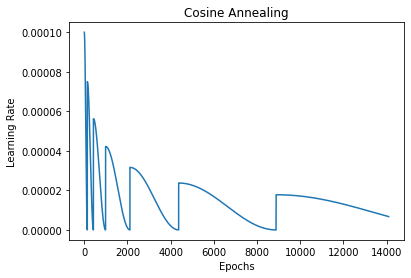

In [ ]:
steps_list = range(100*141)
lr_list = [lr_Cosine_Decay(step) for step in steps_list]

plot_scheduler(steps_list, lr_list, title="Cosine Annealing")

In [ ]:
model.compile(optimizer=Adam(lr_Cosine_Decay), loss="categorical_crossentropy",
                  metrics=["accuracy"])
 
hist = model.fit(train_loader, batch_size=train_batch_size, epochs=100, validation_data=val_loader, shuffle=True, verbose=1,
                 callbacks=[earlystop])

Epoch 1/100
141/141 [==============================] - 163s 925ms/step - loss: 2.0345 - accuracy: 0.2600 - val_loss: 2.2724 - val_accuracy: 0.0862
Epoch 2/100
141/141 [==============================] - 128s 902ms/step - loss: 0.8713 - accuracy: 0.7682 - val_loss: 2.2357 - val_accuracy: 0.1040
Epoch 3/100
141/141 [==============================] - 127s 898ms/step - loss: 0.2621 - accuracy: 0.9285 - val_loss: 1.7067 - val_accuracy: 0.4080
Epoch 4/100
141/141 [==============================] - 127s 901ms/step - loss: 0.2386 - accuracy: 0.9357 - val_loss: 0.4806 - val_accuracy: 0.8493
Epoch 5/100
141/141 [==============================] - 127s 897ms/step - loss: 0.1455 - accuracy: 0.9576 - val_loss: 0.1933 - val_accuracy: 0.9387
Epoch 6/100
141/141 [==============================] - 127s 900ms/step - loss: 0.1197 - accuracy: 0.9660 - val_loss: 0.1059 - val_accuracy: 0.9680
Epoch 7/100
141/141 [==============================] - 127s 898ms/step - loss: 0.1178 - accuracy: 0.9673 - val_loss: 0

In [ ]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

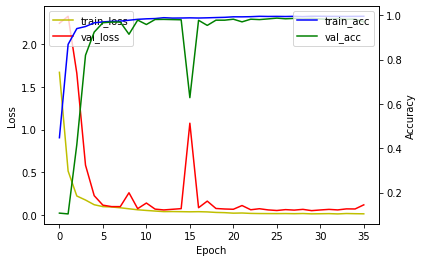

In [ ]:
acc_loss_plot(hist)

In [ ]:
def y_train_writting(test_set_pics, test_set_names):

    """
    test_set_pics: X_test(numpy ndarray) or test_loader(enumerable)
    test_set_names: y_test (pandas DataFrame)
    """

    pred_integral = np.argmax(model.predict(test_set_pics), axis=-1)

    pred_categorical = []

    for prediction in pred_integral:

        if 0 <= prediction <= 8:
            pred_categorical.append(category[prediction])
        
        else:
            raise ValueError("Not a valid integral prediction.")
    
    test_set_names["pred"] = pred_categorical
    print(test_set_names)

    tm = time.localtime()
    file_name = "{0}{1}{2}_{3}{4}{5}".format(str(tm.tm_year).zfill(4),
                                             str(tm.tm_mon).zfill(2),
                                             str(tm.tm_mday).zfill(2),
                                             str(9 + tm.tm_hour).zfill(2),
                                             str(tm.tm_min).zfill(2),
                                             str(tm.tm_sec).zfill(2))

    test_set_names.to_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/answersheet/{0}.csv".format(file_name), mode="w")
    print("The answer sheet file is saved as {}.csv".format(file_name))

In [ ]:
y_train_writting(test_loader, y_test_list)

              files                 pred
0     test10013.jpg               krusty
1     test10019.jpg         ned_flanders
2     test10028.jpg         ned_flanders
3     test10074.jpg   charles_montgomery
4     test10084.jpg         lisa_simpson
...             ...                  ...
1081  test29955.jpg               krusty
1082  test29959.jpg          moe_szyslak
1083  test29963.jpg               krusty
1084  test29984.jpg  milhouse_van_houten
1085  test29998.jpg               krusty

[1086 rows x 2 columns]
The answer sheet file is saved as 20210515_212455.csv


## CNN Modeling 4 (ResNet 101)

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, ResNet50V2, ResNet101V2, Xception

input_tensor= Input(shape=(224, 224, 3))

base_model = ResNet101V2(input_tensor=input_tensor, include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(128, activation="relu", name="FC")(x)   # Dense 하나 더?
x = Dropout(rate=0.2)(x)
output = Dense(9, activation="softmax", name="Output")(x)


model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
def lrfn(epoch):
    LR_START = 1e-5
    LR_MAX = 1e-2
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 5
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = ((LR_MAX - LR_START) / LR_RAMPUP_EPOCHS) * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
        
        print('epoch:', 1 + epoch, 'lr:', lr)
        
        return lr
    
    # 반드시 내포 함수인 calc_fn(epoch)를 호출해야함. 
    return calc_fn(epoch)

In [ ]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10,
                          verbose=1, mode="auto", baseline=None,
                          restore_best_weights=True)

### Cosine Decay Annealing

lr_Cosine_Decay = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=1e-4, first_decay_steps=141,
    t_mul=2, m_mul=0.8, alpha=0.0, name=None
)

### lr scheduler
lr_scheduler = LearningRateScheduler(lrfn)

In [ ]:
def plot_scheduler(epochs_list, lr_list, title=None):
    plt.figure(figsize=(6,4))
    plt.plot(epochs_list, lr_list)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title(title)

epoch: 1 lr: 1e-05
epoch: 2 lr: 0.0020080000000000002
epoch: 3 lr: 0.004006
epoch: 4 lr: 0.006004000000000001
epoch: 5 lr: 0.008002
epoch: 6 lr: 0.01
epoch: 7 lr: 0.01
epoch: 8 lr: 0.01
epoch: 9 lr: 0.01
epoch: 10 lr: 0.01
epoch: 11 lr: 0.01
epoch: 12 lr: 0.01
epoch: 13 lr: 0.0075
epoch: 14 lr: 0.0075
epoch: 15 lr: 0.005625
epoch: 16 lr: 0.005625
epoch: 17 lr: 0.00421875
epoch: 18 lr: 0.00421875
epoch: 19 lr: 0.0031640625
epoch: 20 lr: 0.0031640625
epoch: 21 lr: 0.002373046875
epoch: 22 lr: 0.002373046875
epoch: 23 lr: 0.00177978515625
epoch: 24 lr: 0.00177978515625
epoch: 25 lr: 0.0013348388671875
epoch: 26 lr: 0.0013348388671875
epoch: 27 lr: 0.001001129150390625
epoch: 28 lr: 0.001001129150390625
epoch: 29 lr: 0.0007508468627929688
epoch: 30 lr: 0.0007508468627929688
epoch: 31 lr: 0.0005631351470947266
epoch: 32 lr: 0.0005631351470947266
epoch: 33 lr: 0.00042235136032104493
epoch: 34 lr: 0.00042235136032104493
epoch: 35 lr: 0.0003167635202407837
epoch: 36 lr: 0.0003167635202407837
e

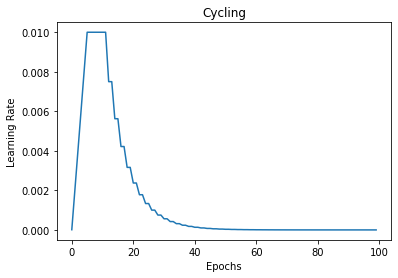

In [ ]:
epoch_list = range(100)
lr_list = [lrfn(epoch) for epoch in epoch_list]

plot_scheduler(epoch_list, lr_list, title="Cycling")

In [ ]:
model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay), loss="categorical_crossentropy",
                  metrics=["accuracy"])
 
hist = model.fit(train_loader, batch_size=train_batch_size, epochs=100, validation_data=val_loader, verbose=1,
                 callbacks=[earlystop], shuffle=True)

Epoch 1/100
141/141 [==============================] - 109s 690ms/step - loss: 1.6851 - accuracy: 0.4202 - val_loss: 0.3586 - val_accuracy: 0.8884
Epoch 2/100
141/141 [==============================] - 96s 679ms/step - loss: 0.3276 - accuracy: 0.9022 - val_loss: 0.1566 - val_accuracy: 0.9511
Epoch 3/100
141/141 [==============================] - 95s 672ms/step - loss: 0.1592 - accuracy: 0.9515 - val_loss: 0.1116 - val_accuracy: 0.9702
Epoch 4/100
141/141 [==============================] - 95s 669ms/step - loss: 0.1387 - accuracy: 0.9594 - val_loss: 0.1255 - val_accuracy: 0.9662
Epoch 5/100
141/141 [==============================] - 95s 671ms/step - loss: 0.1007 - accuracy: 0.9701 - val_loss: 0.0883 - val_accuracy: 0.9751
Epoch 6/100
141/141 [==============================] - 95s 671ms/step - loss: 0.0780 - accuracy: 0.9753 - val_loss: 0.0824 - val_accuracy: 0.9760
Epoch 7/100
141/141 [==============================] - 96s 676ms/step - loss: 0.0648 - accuracy: 0.9820 - val_loss: 0.0789 

In [ ]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

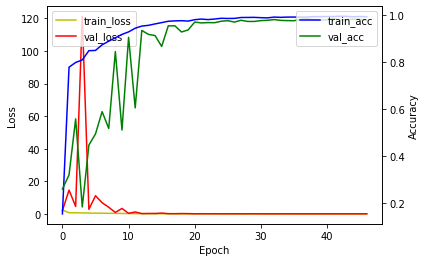

In [ ]:
acc_loss_plot(hist)

In [ ]:
def y_train_writting(test_set_pics, test_set_names):

    """
    test_set_pics: X_test(numpy ndarray) or test_loader(enumerable)
    test_set_names: y_test (pandas DataFrame)
    """

    pred_integral = np.argmax(model.predict(test_set_pics), axis=-1)

    pred_categorical = []

    for prediction in pred_integral:

        if 0 <= prediction <= 8:
            pred_categorical.append(category[prediction])
        
        else:
            raise ValueError("Not a valid integral prediction.")
    
    test_set_names["pred"] = pred_categorical
    print(test_set_names)

    tm = time.localtime()
    file_name = "{0}{1}{2}_{3}{4}{5}".format(str(tm.tm_year).zfill(4),
                                             str(tm.tm_mon).zfill(2),
                                             str(tm.tm_mday).zfill(2),
                                             str(9 + tm.tm_hour).zfill(2),
                                             str(tm.tm_min).zfill(2),
                                             str(tm.tm_sec).zfill(2))

    test_set_names.to_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/answersheet/{0}.csv".format(file_name), mode="w")
    print("The answer sheet file is saved as {}.csv".format(file_name))

In [ ]:
y_train_writting(test_loader, y_test_list)

              files                 pred
0     test10013.jpg               krusty
1     test10019.jpg         ned_flanders
2     test10028.jpg         ned_flanders
3     test10074.jpg   charles_montgomery
4     test10084.jpg         lisa_simpson
...             ...                  ...
1081  test29955.jpg               krusty
1082  test29959.jpg          moe_szyslak
1083  test29963.jpg               krusty
1084  test29984.jpg  milhouse_van_houten
1085  test29998.jpg               krusty

[1086 rows x 2 columns]
The answer sheet file is saved as 20210517_234641.csv


## Freeze
ResNet101 pretrained model을 사용할 때, 앞의 일정 epoch를 freeze시킴. <br>
여기에서 freeze는 weight를 계산하지 않고 pretrained model의 weight를 그대로 이용하여 학습하는 것을 의미함. <br>
정해진 만큼의 epoch가 진행되면, 이후에는 정상적으로 weight를 계산함.

In [ ]:
from tensorflow.keras.applications import ResNet101V2

input_tensor= Input(shape=(224, 224, 3))

base_model = ResNet101V2(input_tensor=input_tensor, include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(128, activation="relu", name="FC")(x)   # Dense 하나 더?
x = Dropout(rate=0.2)(x)
output = Dense(9, activation="softmax", name="Output")(x)


model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10,
                          verbose=1, mode="auto", baseline=None,
                          restore_best_weights=True)

### Cosine Decay Annealing

lr_Cosine_Decay_1 = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=1e-4, first_decay_steps=141,
    t_mul=2, m_mul=0.8, alpha=0.0, name=None
)

lr_Cosine_Decay_2 = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=(1e-4) * (0.8**3), first_decay_steps=141*7,
    t_mul=2, m_mul=0.8, alpha=0, name=None
)

### lr scheduler
lr_scheduler = LearningRateScheduler(lrfn)

In [ ]:
def lrfn(epoch):
    LR_START = 1e-5
    LR_MAX = 1e-2
    LR_RAMPUP_EPOCHS = 3
    LR_SUSTAIN_EPOCHS = 3
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = ((LR_MAX - LR_START) / LR_RAMPUP_EPOCHS) * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
        
        print('epoch:', epoch, 'lr:', lr)
        
        return lr
    
    # 반드시 내포 함수인 calc_fn(epoch)를 호출해야함. 
    return calc_fn(epoch)

In [ ]:
def plot_scheduler(steps_list, lr_list, title=None):
    plt.figure(figsize=(6,4))
    plt.plot(steps_list, lr_list)
    plt.xlabel("Steps")
    plt.ylabel("Learning Rate")
    plt.title(title)

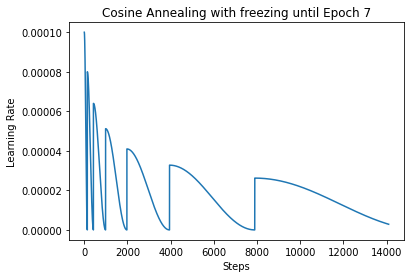

In [ ]:
steps_list = range(141 * 100)
lr_list_1 = [lr_Cosine_Decay_1(step) for step in range(141 * 7)]
lr_list_2 = [lr_Cosine_Decay_2(step) for step in range(141 * 100 - 141 * 7)]

plot_scheduler(steps_list, lr_list_1 + lr_list_2, title="Cosine Annealing with freezing until Epoch 7")

In [ ]:
model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay_1), loss="categorical_crossentropy",
                  metrics=["accuracy"])

for layer in model.layers[:-4]:
    layer.trainable = False

first_epoch = 7
second_epoch = 100 - first_epoch

hist = model.fit(train_loader, batch_size=train_batch_size, epochs=first_epoch, validation_data=val_loader, verbose=1,
                 callbacks=[earlystop])

for layer in model.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay_2), loss="categorical_crossentropy",
                  metrics=["accuracy"])

hist = model.fit(train_loader, batch_size=train_batch_size, epochs=second_epoch, validation_data=val_loader, verbose=1,
                 callbacks=[earlystop])

Epoch 1/7
141/141 [==============================] - 105s 667ms/step - loss: 1.6796 - accuracy: 0.4084 - val_loss: 0.4241 - val_accuracy: 0.8662
Epoch 2/7
141/141 [==============================] - 91s 646ms/step - loss: 0.3415 - accuracy: 0.8996 - val_loss: 0.1676 - val_accuracy: 0.9476
Epoch 3/7
141/141 [==============================] - 91s 643ms/step - loss: 0.1492 - accuracy: 0.9561 - val_loss: 0.1222 - val_accuracy: 0.9640
Epoch 4/7
141/141 [==============================] - 92s 650ms/step - loss: 0.1467 - accuracy: 0.9605 - val_loss: 0.1285 - val_accuracy: 0.9644
Epoch 5/7
141/141 [==============================] - 92s 650ms/step - loss: 0.0843 - accuracy: 0.9770 - val_loss: 0.1019 - val_accuracy: 0.9702
Epoch 6/7
141/141 [==============================] - 91s 646ms/step - loss: 0.0714 - accuracy: 0.9799 - val_loss: 0.0775 - val_accuracy: 0.9756
Epoch 7/7
141/141 [==============================] - 92s 648ms/step - loss: 0.0536 - accuracy: 0.9850 - val_loss: 0.0717 - val_accuracy

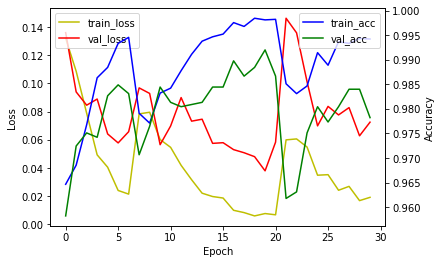

In [ ]:
### 앞의 7번 실행이 빠져 있어서 graph가 난잡해 보임
acc_loss_plot(hist)

In [ ]:
def y_train_writting(test_set_pics, test_set_names):

    """
    test_set_pics: X_test(numpy ndarray) or test_loader(enumerable)
    test_set_names: y_test (pandas DataFrame)
    """

    pred_integral = np.argmax(model.predict(test_set_pics), axis=-1)

    pred_categorical = []

    for prediction in pred_integral:

        if 0 <= prediction <= 8:
            pred_categorical.append(category[prediction])
        
        else:
            raise ValueError("Not a valid integral prediction.")
    
    test_set_names["pred"] = pred_categorical
    print(test_set_names)

    tm = time.localtime()

    if 9 + tm.tm_hour >= 24:
        hour = 9 + tm.tm_hour - 24
    else:
        hour = tm.tm_hour

    file_name = "{0}{1}{2}_{3}{4}{5}".format(str(tm.tm_year).zfill(4),
                                             str(tm.tm_mon).zfill(2),
                                             str(tm.tm_mday).zfill(2),
                                             str(hour).zfill(2),
                                             str(tm.tm_min).zfill(2),
                                             str(tm.tm_sec).zfill(2))

    test_set_names.to_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/answersheet/{0}.csv".format(file_name), mode="w")
    print("The answer sheet file is saved as {}.csv".format(file_name))

In [ ]:
y_train_writting(test_loader, y_test_list)

              files                 pred
0     test10013.jpg               krusty
1     test10019.jpg         ned_flanders
2     test10028.jpg         ned_flanders
3     test10074.jpg   charles_montgomery
4     test10084.jpg         lisa_simpson
...             ...                  ...
1081  test29955.jpg               krusty
1082  test29959.jpg          moe_szyslak
1083  test29963.jpg               krusty
1084  test29984.jpg  milhouse_van_houten
1085  test29998.jpg               krusty

[1086 rows x 2 columns]
The answer sheet file is saved as 20210518_043357.csv
